# NLP ASSIGNMENT
## Detecting fake news through NLP

In [40]:
#Import required libraries
import pandas as pd
import numpy as np
import itertools

from utils import *
from clf import *

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

In [41]:
#In order to be able to explore the whole DataFrame we have to set the option of maximum number of rows to 5k:
#pd.set_option('display.max_rows',500)
#pd.set_option('max_colwidth',1000)

In [42]:
#Load trainning and test set
train_set=pd.read_csv(filepath_or_buffer='./data/fake_or_real_news_training.csv',sep=',',header=0)
validation_set=pd.read_csv(filepath_or_buffer='./data/fake_or_real_news_test.csv',sep=',',header=0)

# 1. Base Line Model (Without Pre-processing)

## 1.1. DATA EXPLORATION

In [43]:
#Show the structure of the train_set to then evaluate each feature
train_set.head(5)

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. \nThe word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. \nBut that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. \nThe FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. \nThe FBI’s leadership is being warned that the en...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO),"Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will never be president. Today proved it. \nIn a particularly staggering example of political cowardice, Paul Ryan re-re-re-reversed course and announced that he was back on the Trump Train after all. This was an aboutface from where he was a few weeks ago. He had previously declared he would not be supporting or defending Trump after a tape was made public in which Trump bragged about assaulting women. Suddenly, Ryan was appearing at a pro-Trump rally and boldly declaring that he already sent in his vote to make him President of the United States. It was a surreal moment. The figurehead of the Republican Party dosed himself in gasoline, got up on a stage on a chilly afternoon in Wisconsin, and lit a match. . @SpeakerRyan says he voted for @realDonaldTrump : “Republicans, it is time to come home”...",FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,"U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a countr...",REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!',"— Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. \n— People For Bernie (@People4Bernie) November 9, 2016 If Dems didn't want a tight race they shouldn't have worked against Bernie. \n— Walker Bragman (@WalkerBragman) November 9, 2016 \nNew York Times columnist Paul Krugman, who was one of Hillary Clinton’s most outspoken surrogates during the contentious Democratic primary, blamed Clinton’s poor performance on Green Party candidate Jill Stein, who has so far received a negligible number of votes nationally, sayin

The target variable is label. Label should have only 2 values:
* Fake
* Real

However it can be seen that initially this is not the case. There are a total of 35 different values for label, which means that **33 values are incorrect**.

In [5]:
n_classes=train_set['label'].value_counts().count()
print(f'The total number of values under the label column are {n_classes}')

The total number of values under the label column are 35


It seems that the X1 and X2 are mostly empty so we are going to evaluate the missing values in each feature.

In [6]:
# Using the own defined missing_values_table function,features that have missing values and the percentage is summarized
missing_values_table(train_set)

Your selected dataframe has 6 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
X2,3997,99.9
X1,3966,99.2


In [7]:
################################################################################
# I would remove this since the pd.value_counts() already provides a histogram #
################################################################################
#np.unique(train_set.label).head()

It seems that the X1 and X2 features have some useful information and that the "label" feature has some mistaken rows. Thus we are going to determine how many rows have a different value than FAKE or REAL. 

In [8]:
len(train_set[~((train_set.label == 'FAKE') | (train_set.label == 'REAL'))])

33

## 1.2.DATA CLEANING


### Fixing incorrect rows

To understand what is happening with those 33 rows that have errors in the label we are going to separate them from the train_set to then do some EDA.

In [9]:
incorrect_rows = train_set[~((train_set.label == 'FAKE') | (train_set.label == 'REAL'))]
incorrect_rows
#BREO: I think all these have in common that they have underheader, so they have title, subtitle and text

,ID,title,text,label,X1,X2
192,599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,"Election Day: No Legal Pot In Ohio; Democrats Lose In The South\n\nTuesday is ""off year"" Election Day in parts of the country. Legalizing marijuana is on the ballot in Ohio, Houston voters will decide on an equal rights ordinance and San Francisco weighs short-term rentals in what's being called the ""Airbnb Initiative.""\n\nElsewhere, eyes are on governor races in Kentucky and Louisiana, and whether Democrats can make any progress in the South.\n\nHere's a look at some of the races:\n\nHouston voters will decide whether to keep an equal rights ordinance that was approved by the City Council last year. The Houston Equal Rights Ordinance (HERO) would ban discrimination based on sexual orientation and gender identity — criteria not covered by national anti-discrimination laws. The ordinance is hotly debated, particularly after some opposition ads were released. The ads claim that the ordinance would allow men who identify as women to assault women and young girls in bathrooms.\n\nHilla...",REAL,NaN
308,10194,Who rode it best? Jesse Jackson mounts up to fight pipeline,Leonardo DiCaprio to the rescue?,"Who rode it best? Jesse Jackson mounts up to fight pipeline; Leonardo DiCaprio to the rescue? Posted at 6:41 pm on October 26, 2016 by Brett T. Share on Facebook Share on Twitter \nVladimir Putin might have popularized the shirtless-on-horseback calendar pose that was echoed recently by Alex Jones , but Jesse Jackson deserves credit for at least one thing: he chose to keep his shirt on Wednesday when he rode up to the front lines of a protest against the Dakota Access Pipeline. \n— Marisa Villarreal (@marisa_villarr) October 26, 2016 Proud to stand with the Sioux Indians today in North Dakota. #StandingWithStandingRock pic.twitter.com/0dPbDk6RJD \n— Rev Jesse Jackson Sr (@RevJJackson) October 26, 2016 Jesse Jackson on the frontline with that native bling #NoDAPL pic.twitter.com/QevCYFugN3 \n— Ruth Hopkins (@RuthHHopkins) October 26, 2016 \nSeen standing with Jackson (literally; check over his shoulder above) was “Avengers” actor Mark Ruffalo, who offered his own exclusive scoop of ...",FAKE,NaN
382,356,Black Hawk crashes off Florida,human remains found,"(CNN) Thick fog forced authorities to suspend the air search Wednesday for seven Marines and four Army aircrew, feared dead after their Black Hawk helicopter crashed into waters off the Florida Panhandle.\n\nThe helicopter was first reported missing at about 8:30 p.m. (9:30 p.m. ET) Tuesday. Hours later, searchers found debris around Okaloosa Island near Eglin Air Force Base, base spokesman Andy Bourland said.\n\nThis debris washed up on both the north and south sides of Santa Rosa Sound, which connects mainland northern Florida and a barrier island.\n\nThe air search is expected to resume midday Thursday, the spokesman said. A spokeswoman for the Coast Guard said that boats will continue scouring the waters throughout the night Wednesday, weather permitting.\n\nHuman remains have washed ashore in the area near Eglin.\n\nBase spokeswoman Jasmine Porterfield didn't specify what was found, noting the search-and-rescue mission remained underway. Still, there was little hope for a mira...",REAL,NaN
660,2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,"(CNN) Aerial bombardments blew apart a Doctors Without Borders hospital in the battleground Afghan city of Kunduz about the time of a U.S. airstrike early Saturday, killing at least 19 people, officials said.\n\nThe blasts left part of the hospital in flames and rubble, killing 12 staffers and seven patients -- including three children -- and injuring 37 other people, the charity said.\n\nAs the United States said it was investigating what struck the hospital during the night, the charity expressed shock and demanded answers, stressing that all combatants had been told long ago where the hospital was.\n\n""(The bombing)

It seems that the error happened when reading the data because of some delimiters used for the text, dividing it into two features when it should have been just one. 

Thus, we are going to concatenate those rows and assign the result to the variable text, and assign the proper labels that are stored in X1 to the label variable.

Finally, we are going to print the final result to evaluate if the error has been corrected.

In [10]:
#Breo did this
#incorrect_rows_2=incorrect_rows[~((incorrect_rows['label']=='FAKE')|(incorrect_rows['label']=='REAL'))]
#incorrect_rows_2.label=incorrect_rows_2.X2

In [11]:
incorrect_rows.text = incorrect_rows.text + incorrect_rows.label
incorrect_rows.label = incorrect_rows.X1

incorrect_rows[~((incorrect_rows.label == 'FAKE') | (incorrect_rows.label == 'REAL'))]

,ID,title,text,label,X1,X2
2184,9,Planned Parenthood’s lobbying effort,pay raises for federal workers and the future Fed rates,"PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE. Congress may have spent August away from Washington but Planned Parenthood’s campaign to convince lawmakers to protect the group’s funding followed them back to their home states. Power Post has more.\n\n“Lawmakers will raise the stakes when Congress returns next week by threatening to defund the group through the federal appropriations process. Planned Parenthood’s counter-offensive is widespread and varied and is unfolding inside and outside the Beltway. The group has been organizing rallies, flooding lawmakers’ town hall meetings, commissioning polls, shelling out six figures for television ads and hiring forensics experts to try to discredit undercover video footage that sparked the controversy. The success of these lobbying efforts will be tested when Congress returns and must move a short-term spending bill to keep the government open. Some conservatives in both chambers are pushing to defund Planned Parenthood, even if a standof...","PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE. Congress may have spent August away from Washington but Planned Parenthood’s campaign to convince lawmakers to protect the group’s funding followed them back to their home states. Power Post has more.\n\n“Lawmakers will raise the stakes when Congress returns next week by threatening to defund the group through the federal appropriations process. Planned Parenthood’s counter-offensive is widespread and varied and is unfolding inside and outside the Beltway. The group has been organizing rallies, flooding lawmakers’ town hall meetings, commissioning polls, shelling out six figures for television ads and hiring forensics experts to try to discredit undercover video footage that sparked the controversy. The success of these lobbying efforts will be tested when Congress returns and must move a short-term spending bill to keep the government open. Some conservatives in both chambers are pushing to defund Planned Parenthood, even if a standof...",REAL
3537,6268,Chart Of The Day: Since 2009—–Recovery For The 5%,Stagnation for the 95%Chart Of The Day: Since 2009 Recovery For The 5%,Stagnation for the 95%,Stagnation for the 95%,FAKE


It seems that there are still two rows with errors which labels are in X2, thus we are going to assign the corrected rows in a variable, to then assign the incorrect rows to another variable where we will assign the correct label. Finally, we will concatenate both variables into a single variable and evaluate if the labels have been fixed.

In [12]:
#  Fixing the remaining rows with errors
corrected_rows = incorrect_rows[((incorrect_rows.label == 'FAKE') | (incorrect_rows.label == 'REAL'))]
incorrect_rows = incorrect_rows[~((incorrect_rows.label == 'FAKE') | (incorrect_rows.label == 'REAL'))]

incorrect_rows.label = incorrect_rows.X2

corrected_rows = pd.concat([corrected_rows,incorrect_rows],ignore_index=True)
np.unique(corrected_rows.label)

array(['FAKE', 'REAL'], dtype=object)

All the wrong labels have been corrected, thus we are going to filter the train_set just with the correct rows to then concatenate it with the corrected ones. Finally, we are going to filter the X1 and X2 columns as they do not have any useful information anymore.

In [13]:
# Subsetting the train_set to eliminate the rows with errors to then concatenate it with the fixed ones
train_set = train_set[((train_set.label == 'FAKE') | (train_set.label == 'REAL'))]
train_set = pd.concat([train_set,incorrect_rows],ignore_index=True)

# Subsetting the train_set to not work with the features X1 and X2 as they are 100% empty after fixing the
# rows with errors
train_set = train_set[["ID","title","text","label"]]

In [14]:
np.unique(train_set.label)

array(['FAKE', 'REAL'], dtype=object)

### Target variable distribution on trainning set

Once the dataset is cleaned, it is necessary to check the proportion of the different values of the target variable to make sure it is a balanced dataset. As depicted below, the **dataset is balanced** regarding the target variable.

In [15]:
calculate_target_proportion(train_set)

REAL:  1991 instances    50.2%
FAKE:  1977 instances    49.8%


## 1.3. Extracting and training data

### Defining train and test set
Once the dataset has been cleaned is time to separate the labels and prepare the training and test set

In [16]:
# Set independent and dependent variables x and y
x = train_set.text
y = train_set.label

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=198374)

### Building Vectorized Classifiers
In order to determine if the words and tokens in the articles have a discriminative power to determine if the news are FAKE or REAL CountVectorizer (Bag of Words) and TfidfVectorizer will be used.

In order to elminate the words that appear in more than 70% of the articles (no discriminative power) the parameter max_df of the TfidfVectorizer will be set to 0.7. Additionaly, the stop_words parameter will be added to the CountVectorizer function to remove them due to the same reason. 

#### CountVectorizer

In [17]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

#### TfidfVectorizer

In [18]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

#### Results Analysis

In [19]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])
#print(tfidf_vectorizer.get_feature_names())

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])
#print(count_vectorizer.get_feature_names())

['ź50', 'ελληνικά', 'октября', 'русский', 'эa', 'эin', 'эthe', 'яркий', 'عربي', 'ยงade']
['00', '000', '0000', '00000031', '0002', '000billion', '000km', '001', '003', '004']


As it can be seen there is still a lot of noise in the dataset, thus the pre-processing step will be run iteratively until a sort of clean dataset is obtained.



NAIVE BAYES CLASSIFIER
-------------------------------------
NB with TfIdf accuracy:   0.811
NB with Tf accuracy:   0.882


PASSIVE AGGRESIVE CLASSIFIER
-------------------------------------
Passive Aggresive with TfIdf accuracy:   0.915
Passive Aggresive with Tf accuracy:   0.869


MAXIMUM ENTROPY CLASSIFIER
-------------------------------------
Maximum Entropy with TfIdf accuracy:   0.895
Maximum Entropy with Tf accuracy:   0.895


SVM CLASSIFIER
-------------------------------------
SVM with TfIdf accuracy:   0.490
SVM with Tf accuracy:   0.732


The best model is passive_clf_tfidf with an accuracy of: 0.915


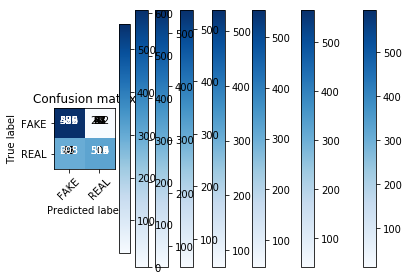

In [20]:
classifiers(count_train,count_test,tfidf_train,tfidf_test,y_train, y_test)

## 1.4. Modelling

### Confusion Matrix
Firstly, a function to plot the confusion matrix of the models will be implemented due to the importance that false positives have in Fake News analysis, as it may be better not to classify a Real News as Fake. This function is defined in the **[utils.py](./utils.py)** file as **plot_confusion_matrix**.

We are going to try several models over the **TfIdf** and **TF(Bag-of-words)** approach to determine the one with the highest performance, then we are going to work on the hyperparameter tunning and cross validation to try to improve its value.

### Naive Bayes
The first model that will be tested is the Naive Bayes classifier which is the most common model used for NLP tasks.

In [21]:
# Model definition
clf = MultinomialNB() 

#### Naive Bayes performance with TfIdf

accuracy:   0.811


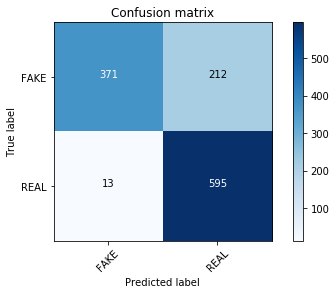

In [22]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### Naive Bayes performance with Bag-of-words

accuracy:   0.882


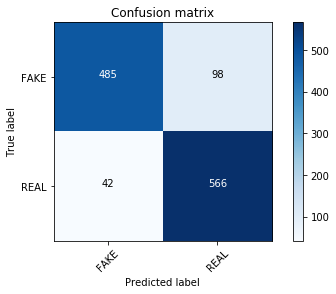

In [23]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### Pasive Agressive Classifier

In [24]:
linear_clf = PassiveAggressiveClassifier(n_iter=50)

#### Pasive Aggresive Classifier performance with TfIdf

accuracy:   0.913


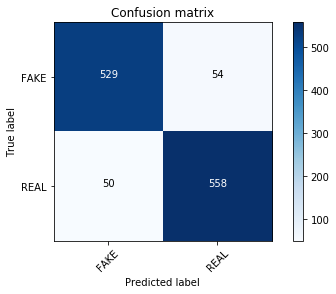

In [25]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### Pasive Aggresive Classifier performance with Bag-of-words

accuracy:   0.868


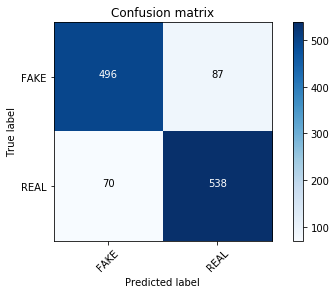

In [26]:
linear_clf.fit(count_train, y_train)
pred = linear_clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### MaxEnt (Logistic Regression) Classifier
...

In [27]:
max_ent = LogisticRegression()

#### MaxEnt Classifier performance with TfIdf

accuracy:   0.895


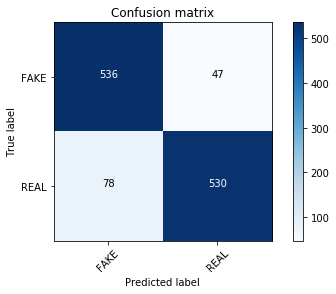

In [28]:
max_ent.fit(tfidf_train, y_train)
pred = max_ent.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### MaxEnt Classifier performance with Bag-of-words

accuracy:   0.895


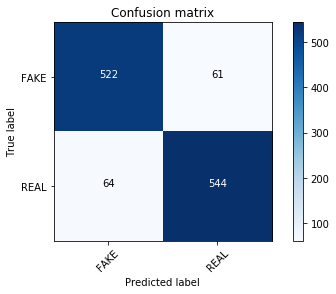

In [29]:
max_ent.fit(count_train, y_train)
pred = max_ent.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

### Support Vector Machine Classifier
...

In [30]:
svc_clf = SVC()

#### SVM Classifier performance with TfIdf

accuracy:   0.490


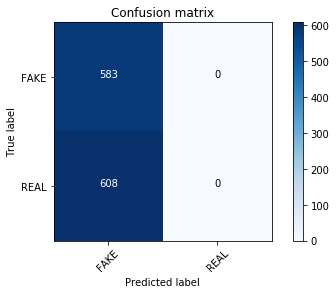

In [31]:
svc_clf.fit(tfidf_train, y_train)
pred = svc_clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

#### SVM Classifier performance with Bag-of-words

accuracy:   0.732


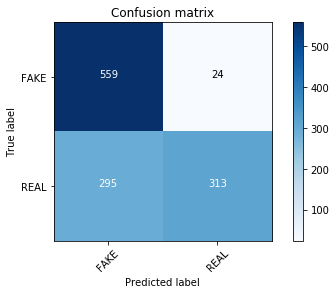

In [32]:
svc_clf.fit(count_train, y_train)
pred = svc_clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

## Model Tunning
The model with the best performance was the Passive Aggressive Classifier over the TfIdf vectorizer. Thus, the following steps will try to optimize the hyperparameters and apply cross-validation to determine stability of the model.

### Building a Pipeline

In [33]:
# Split the dataset into train and test set (hold-out)
X_train, X_test= tfidf_train, tfidf_test

# Set the parameters by cross-validation
tuned_parameters = [{'n_iter': [5, 50, 200, 1000], 'random_state':[3457]}]

scores = ['recall', 'precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(PassiveAggressiveClassifier(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")#Cambiamos full development test por train_set
    print("The scores are computed on the full evaluation set.")#Cambiamos full evaluation set por test within the train set
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'n_iter': 5, 'random_state': 3457}

Grid scores on development set:

0.922 (+/-0.030) for {'n_iter': 5, 'random_state': 3457}
0.921 (+/-0.028) for {'n_iter': 50, 'random_state': 3457}
0.921 (+/-0.028) for {'n_iter': 200, 'random_state': 3457}
0.921 (+/-0.028) for {'n_iter': 1000, 'random_state': 3457}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

        FAKE       0.91      0.91      0.91       583
        REAL       0.92      0.92      0.92       608

   micro avg       0.92      0.92      0.92      1191
   macro avg       0.92      0.92      0.92      1191
weighted avg       0.92      0.92      0.92      1191


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_iter': 5, 'random_state': 3457}

Grid scores on develo

# 2. Improved model with Preprocessing

Now the influence of preprocessing is going to be analysed. For this reason some cleaning and preprocessing steps are going to be performed. 

## 2.1. Data Cleansing


## DATA PRE-PROCESSING

Exploring the training_set it can be noticed that in the pre-processing step we need to deal with:
* **New lines** are started with the **"\n"** character
* **Paragraphs** are initiated with  **"\n\n"** character
* @ symbols, Do we process them?
* '•','©',':','>>' symbols must be deleted for the purpose of classifying
* Stop words must be removed (for classification purposes)

### Normalization
From the exploratory part, the following normalization process must be handled:
* Capital letters to lower case
* Lemmatization

### Words longer than 30 letters (To be removed as soon as checking if word belongs to English is finished)

According to the following reference: [What is the longest English word?](https://en.oxforddictionaries.com/explore/what-is-the-longest-english-word/ ), the maximum length is 29 letters. So anything higher than that is not a word. Delete or use as feature?

In [34]:
features=... #features of the TFVectorizedCounter

In [35]:
over_30=[feature for feature in features if (len(feature)>=30)]
over_30[:5],over_30[-5:]

TypeError: 'ellipsis' object is not iterable

In [ ]:
print(f'There are {len(over_30)} features with length larger than 30')

### Words not belonging to english

Our dataset has news only in English; however, some news in our data sets have words in other languages, so is there any way to detect those words which do not belong to English?

We can try to use all the words in the **nltk corpus** and consider them as the all the existing vocabulary of the English language...

In [ ]:
def word_in_corpus(words):
    '''Function that removes all non-English words from an input list
    :input: list of tokenized words
    :output: string with only words in English
    '''
    from nltk.corpus import words as corpus_dictionary
    
    news_string=''
    for word in words:
        if word.lower() in corpus_dictionary.words():
            news_string+=' '+word.lower()
    return news_string

In [ ]:
my_list=word_tokenize('This is the ~ worst sentence 文本 I & wrote SiNcE my primo de Barcelona wnet to @ Madrid! , Chicago , Washington , Russia , Romania, 北京',language='english')

In [ ]:
word_in_corpus(my_list)

If the corpus is used, names of entities and special characters will not be considered as English, so using this function would elminate too much data.

We can also try to use complete dictionaries that include names of entities, completting it with special punctuation characters trying to address above issues:

In [ ]:
import json
##############################ADD NER?????#######################
from string import punctuation
set(punctuation)   

def words_in_dictionary(words):
    collection=json.load(open('words_dictionary.json'))
    
    news_string=''
    for word in words:
        if word.lower() in collection:
            news_string+=' '+word.lower()
    return news_string    
    

In [ ]:
words_in_dictionary(my_list)

In [ ]:
def non_english_words_in_df(df,label=[1,2]):
    '''Function that reads all the rows of a dataframe en detect non-existing words in English'''
    '''For dev: first create a new column to compare the result, when sure, overwrite the column'''
    for column in label:
    # Every loop in i is a new row in the dataframe
        for i in range(df.shape[0]):
            # tokenize each row
            text_list = word_tokenize(str(df.iloc[i, column]), language='english')


            if column == 1:
                stamp = 'title_english'
            elif column == 2:
                stamp = 'text_english'

            df.at[i, stamp] = word_in_corpus(text_list)
            text_list = []

    return df

In [ ]:
#https://pypi.org/project/PyDictionary/
#'Download a corpus', if word in corpus, then is english, otherwise not english.
#pip install PyDictionary
from PyDictionary import PyDictionary

In [ ]:
dict=PyDictionary()

In [ ]:
type(dict.meaning('Madr'))

In [ ]:
def english_words(word):
    '''This function takes a word and determines if it exist in English'''
    
    dict=PyDictionary()
    output=dict.meaning(word)
    return output

In [ ]:
error_message='The Following Error occured'
if type(english_words('heo'))=='NoneType':
    print('No english word')

## 2.2. Text Normalization
### Case Sensitive

Both, CountVectorizer and TfidfVectorizer functions have a parameter called **'lowercase'** which deals with the case sensitive problem. However, as it will be presented below, **lower case** is an issue that needs to be handle **during LEMMATIZATION** 

### Lemmatization

Another normalization step is to perform lemmatization to obtain the lemma of the words. This in some way is reducing the number of features, as some words that were different (go, going, went) now will be only one word (go). For such purpose a function called **lemmatizer** was created to perform such operation in the title and text columns of our dataframe.

In [ ]:
train_set_2=train_set.copy(deep=True)

In [ ]:
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

**Lemmatizer curiosity**  
If the word is lowercase, the lematizer works well:

In [ ]:
lower_case_list=['cats','dogs','went','found','women']
for word in lower_case_list:
    print(word+' --> '+str( WordNetLemmatizer().lemmatize(word,pos='v')))

However, if capital letters are used, the lemmatizer does not work so well:

In [ ]:
upper_case_list=['Cats','Dogs','Went','Found','Women']
for word in upper_case_list:
    print(word+' --> '+str( WordNetLemmatizer().lemmatize(word,pos='v')))

Therefore, we need to **convert to lower case every word before lemmatizing**.

In [ ]:
%%time
wordnet_lemmatizer(train_set_2)

In [ ]:
# Set independent and dependent variables x and y
x = train_set_2.text_wordnet_lemmatized
y = train_set_2.label

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=198374)

In [ ]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(lowercase=True,max_df=0.7)

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

In [ ]:
len(count_vectorizer.get_feature_names())

In [ ]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(lowercase=True,stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
classifiers(count_train,count_test,tfidf_train,tfidf_test,y_train, y_test)

In [ ]:
# Split the dataset into train and test set (hold-out)
X_train, X_test= tfidf_train, tfidf_test

# Set the parameters by cross-validation
tuned_parameters = [{'n_iter': [5, 50, 200, 1000], 'random_state':[3457]}]

scores = ['recall', 'precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(PassiveAggressiveClassifier(), tuned_parameters, cv=10,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# 3. Improved Model (POS tagging with ngrams)

In [18]:
train_set_3=train_set.copy(deep=True)

pandas.core.frame.DataFrame

In [ ]:
#Esta función la dejé corriendo casi 12horas y no terminó...ver cómo hacerla más rápida (quitar 4-grams,...?) o correrla en cluster...
%%time
ngram_lemmatizer(train_set_3)

In [ ]:
# Set independent and dependent variables x and y
x = train_set_3.text_lemmatized
y = train_set_3.label

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=198374)

In [ ]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(lowercase=True,max_df=0.7)

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

In [ ]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Falta por hacer:
* train con sólo text, sólo title, title+text (Sebastián)-->Usa la función classifiers() en [clf.py](./clf.py) para pasarle los distintos tfidf y tf. En 6 líneas puedes probar todas las combinaciones (text y/o title) con todos los clasificadores que hemos definido en este proyecto.
* cambiar caracteres especiales a 'tags' (Sebastián)
* Introducir NER en la parte de reconocer palabras inglesas (Breo)
* Arreglar función classifiers() para que la confusion matrix aparezca bien (Breo)